# Jake's exploration

In [110]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf
import re

In [111]:
df = pd.read_csv("ted_main.csv")
print df.dtypes

comments               int64
description           object
duration               int64
event                 object
film_date              int64
languages              int64
main_speaker          object
name                  object
num_speaker            int64
published_date         int64
ratings               object
related_talks         object
speaker_occupation    object
tags                  object
title                 object
url                   object
views                  int64
dtype: object


### Do the average number of views from related videos affect views on the video?

In [112]:
related_view = []
for idx, row in df.iterrows():
    view_m = re.findall('\'viewed_count\': [0-9]+', row.related_talks)
    total_views = 0
    num_related_vids = 0
    for v in view_m:
        vs = re.search('[0-9]+', v)
        num_related_vids += 1
        total_views += int(vs.group(0))
    related_view.append(total_views / num_related_vids)
df['avg_related_views'] = pd.Series(data=related_view, index=df.index)

print df.dtypes

comments               int64
description           object
duration               int64
event                 object
film_date              int64
languages              int64
main_speaker          object
name                  object
num_speaker            int64
published_date         int64
ratings               object
related_talks         object
speaker_occupation    object
tags                  object
title                 object
url                   object
views                  int64
avg_related_views      int64
dtype: object


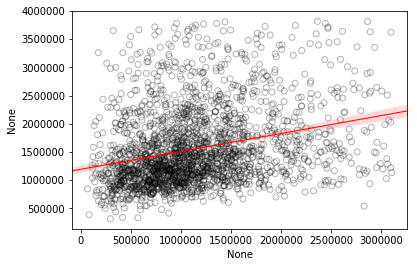

In [131]:
q1_related = df["avg_related_views"].quantile(0.25)
q3_related = df["avg_related_views"].quantile(0.75)
q1 = df["views"].quantile(0.25)
q3 = df["views"].quantile(0.75)
no_outliers = [row.avg_related_views if row.avg_related_views < q3_related + (q3_related - q1_related) * 1.5 else np.nan for idx, row in df.iterrows()]
xaxis = [row.views if row.views < q3 + (q3 - q1) * 1.5 else np.nan for idx, row in df.iterrows()]
xaxis = [xaxis[idx] if not np.isnan(no_outliers[idx]) else np.nan for idx, row in df.iterrows()]
no_outliers = [no_outliers[idx] if not np.isnan(xaxis[idx]) else np.nan for idx, row in df.iterrows()]

for i in range(len(no_outliers)-1, -1, -1):
    if np.isnan(no_outliers[i]):
        no_outliers.pop(i)
        xaxis.pop(i)

for i in range(len(xaxis)-1, -1, -1):
    if np.isnan(xaxis[i]):
        no_outliers.pop(i)
        xaxis.pop(i)

no_outliers = pd.Series(data=no_outliers)
xaxis = pd.Series(data=xaxis)

line_kws={'color':'r', 'lw':1}
scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.3}

sns.regplot(x=xaxis , y=no_outliers, line_kws=line_kws, scatter_kws=scatter_kws)

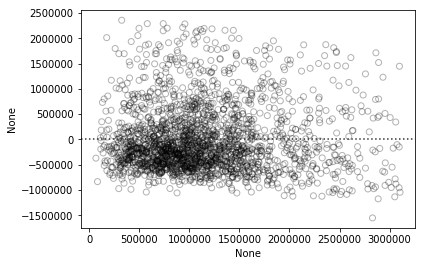

In [132]:
sns.residplot(x=xaxis, y=no_outliers, scatter_kws=scatter_kws)

In [126]:
#xaxis = xaxis.reshape(1, -1)
#no_outliers = no_outliers.reshape(1, -1)
#egr = LinearRegression()
#regr.fit(xaxis, no_outliers)
#r2 = regr.score(xaxis, no_outliers)
#b1 = regr.coef_[0][0]
#print "slope = ", b1
#print "R^2 score is ", r2

#b0 = regr.intercept_
#print "intercept = ", b0[0]

A = np.vstack([no_outliers, np.ones(len(no_outliers))]).T
b1, b0 = np.linalg.lstsq(A, xaxis)[0]
resid = (np.linalg.lstsq(A, xaxis)[1])[0]
r2 = 1 - resid / (no_outliers.size * no_outliers.var())

print "slope = {0:.5f}".format(b1)
print "R^2   = {0:.5f}".format(r2)

slope = 0.24557
R^2   = 0.28663


#### In short, there is a positive linear correlation between video views and the number of views on related videos, but it is a fairly weak one.

### another question